# Analisis exploratorio inicial de datos de CAF

### 2. Proceso ETL
- Carga de datos de parquet a pandas
- Limpieza inicial de los datos
- Tratamiento de datos categoricos
- Tratamiento del campo fecha
- Convertir el campo indice en fecha
- Comprobacion de la frequencia de muestreo
- Ajuste del dataset a la frequencia de muestreo


In [ ]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import io
import os
import datetime
import glob
import math
import geopy.distance
from geographiclib.geodesic import Geodesic

#Modelo SRTM-3
!pip install git+https://github.com/tkrajina/srtm.py.git
import srtm

  Cloning https://github.com/tkrajina/srtm.py.git to /tmp/pip-req-build-ftk0ndy0
  Running command git clone -q https://github.com/tkrajina/srtm.py.git /tmp/pip-req-build-ftk0ndy0
  Created wheel for SRTM.py: filename=SRTM.py-0.3.7-cp37-none-any.whl size=110305 sha256=2980f422ad147643378740203afa20b18949b0249217186e97a130d0234c0d0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-2wz2yxx8/wheels/9d/6b/ff/447ffdd0c60157da2a8768f4b8bea7fe944173ebe5a0f563f0
Successfully built SRTM.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cargamos el dataset



In [ ]:
# Miercoles no festivo
parquet_path = "/content/drive/MyDrive/CAFcoding/dataset/example_parquet/date=2020-11-18/"
csv_path = "/content/drive/MyDrive/CAFcoding/dataset/20201118_fullday_etl.csv"

In [ ]:
dataset = pq.ParquetDataset(parquet_path)
table = dataset.read()

In [ ]:
df = table.to_pandas(timestamp_as_object=True)

# Dataset Meteorológico y SRTM-3

In [ ]:
#Definamos antes funciones que vamos a usar

def distance(latitud, longitud, latitud_1, longitud_1):
  distance = np.nan  #Valor por defecto
  distance = geopy.distance.vincenty((latitud, longitud), (latitud_1, longitud_1))
  return distance.meters

def getNearestStation(longitud, latitud):
  nearestDistance = np.nan  #Valor por defecto
  nearestStation = ''
  for e in station_coords:
    currentDistance = geopy.distance.vincenty((latitud, longitud), (e['lat'], e['long']))
    if currentDistance < nearestDistance:
      nearestDistance = currentDistance
      nearestStation = e
  return e

def getTrainDirection(lat1, long1, lat2, long2):
  geod = Geodesic.WGS84
  g = geod.Inverse(lat1, long1, lat2, long2)
  return g['azi1']

def clean_meteo_df(df_meteo, date_range):
    df_meteo_reduced = df_meteo.loc[(pd.to_datetime(df_meteo['fecha'])>=date_range['min']) & (pd.to_datetime(df_meteo['fecha'])<=date_range['max'])].copy()
    return df_meteo_reduced

def fr_aerodinamic_wind(module, wing_dir, train_dir):
    return module * math.cos(wing_dir - train_dir)

def lat_aerodinamic_wind(module, wing_dir, train_dir):
    return module * math.sin(wing_dir - train_dir)

In [ ]:
colnames=['estacion', 'longitud', 'latitud', 'id', 'ciudad', 'fecha', 'precipitacion_pluviometro_acu', 'precipitacion_disdrometro_acu', 'precipitacion_liquida_acu', 'precipitacion_solida_acu', 'wind_vmax_3s', 'wind_vmean_10m', 'wind_max_ultrasound_10m', 'wind_direction_ultrasound_10m', 'wind_direction_10m', 
          'wind_direction_ultrasound_10m', 'wind_max_direction_60m', 'wind_ultrasound_direction_60m', 'svd_wind_10m', 'svd_wind_direction_10m', 'svd_wind_ultrasonic_10m', 'svd_wind_ultrasonic_direction_10m', 'hri', 'insolation_duration_1h', 'presion_barometro', 'presion_reducida_750', 'temp_ground_10m', 'temp_subground20_10m', 
          'temp_subground5_10m', 'tia', 'temp_rocio', 'tmin', 'tmax', 'visibility10', 'ref_alt_baro_750', 'ref_alt_baro_850', 'ref_alt_baro_925', 'wind_route_60', 'snow_60'] 

path = r'drive/MyDrive/CAFcoding/notebook/utils/meteo_data'
all_files = glob.glob(path + "/*.csv")

li = [pd.read_csv(filename, index_col=None, delimiter=';', header=None) for filename in all_files]


df_meteo = pd.concat(li, axis=0, ignore_index=True)

df_meteo.columns = colnames
df_meteo.head()

,estacion,longitud,latitud,id,ciudad,fecha,precipitacion_pluviometro_acu,precipitacion_disdrometro_acu,precipitacion_liquida_acu,precipitacion_solida_acu,wind_vmax_3s,wind_vmean_10m,wind_max_ultrasound_10m,wind_direction_ultrasound_10m,wind_direction_10m,wind_direction_ultrasound_10m,wind_max_direction_60m,wind_ultrasound_direction_60m,svd_wind_10m,svd_wind_direction_10m,svd_wind_ultrasonic_10m,svd_wind_ultrasonic_direction_10m,hri,insolation_duration_1h,presion_barometro,presion_reducida_750,temp_ground_10m,temp_subground20_10m,temp_subground5_10m,tia,temp_rocio,tmin,tmax,visibility10,ref_alt_baro_750,ref_alt_baro_850,ref_alt_baro_925,wind_route_60,snow_60
0,1074C,-2.706153,43.202892,100.0,AMOREBIETA-SAN MIGUEL DUDEA,2019-02-15T21:00:00,0.0,NaN,NaN,NaN,1.7,0.8,NaN,NaN,92.0,NaN,97.0,NaN,NaN,NaN,NaN,NaN,72.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,8.0,9.7,NaN,NaN,NaN,NaN,NaN,NaN
1,1074C,-2.706153,43.202892,100.0,AMOREBIETA-SAN MIGUEL DUDEA,2019-02-15T22:00:00,0.0,NaN,NaN,NaN,1.5,0.5,NaN,NaN,99.0,NaN,157.0,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,7.0,7.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1074C,-2.706153,43.202892,100.0,AMOREBIETA-SAN MIGUEL DUDEA,2019-02-15T23:00:00,0.0,NaN,NaN,NaN,1.0,0.3,NaN,NaN,169.0,NaN,127.0,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN,NaN,NaN,5.8,NaN,5.8,6.8,NaN,NaN,NaN,NaN,NaN,NaN
3,1074C,-2.706153,43.202892,100.0,AMOREBIETA-SAN MIGUEL DUDEA,2019-02-16T00:00:00,0.0,NaN,NaN,NaN,1.0,0.3,NaN,NaN,246.0,NaN,200.0,NaN,NaN,NaN,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,NaN,4.6,NaN,4.6,5.7,NaN,NaN,NaN,NaN,NaN,NaN
4,1074C,-2.706153,43.202892,100.0,AMOREBIETA-SAN MIGUEL DUDEA,2019-02-16T01:00:00,0.0,NaN,NaN,NaN,0.9,0.3,NaN,NaN,193.0,NaN,355.0,NaN,NaN,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,4.1,4.5,NaN,NaN,NaN,NaN,NaN,NaN


## Generamos transformaciones en nuestro DF y DF_Meteo para el cálculo de variables, merge y limpieza de datos potencialmente incorrectos

In [ ]:
#Primero eliminamos los rows que no nos interesan de df_meteo
date_range = {'min': df['ts_date'].min(), 'max': df['ts_date'].max()}
df_meteo = clean_meteo_df(df_meteo,date_range)

In [ ]:
#Nos quedamos solo con las que tengamos suficientes datos
df_meteo = df_meteo.loc[:, df_meteo.isnull().mean() < .6]

In [ ]:
df = df[df.SI_GPS_LonG > 0] #Todo lo que esté fuera potencial error en datos o fuera de zona de interés
df = df[df.SI_GPS_LatG > 41]
df['Longitud'] = -sum([df.SI_GPS_LonG, (df.SI_GPS_LonM/60), (df.SI_GPS_LonS/3600)]) #Inversa porque está medido de E -> O
df['Latitud'] = sum([df.SI_GPS_LatG, (df.SI_GPS_LatM/60), (df.SI_GPS_LatS/3600)])

In [ ]:
#Este es nuestro rango, se observa algún punto erróneo pero son menores (esta celda y la siguiente no debe pasar a ETL)
b_box = (df.Longitud.min(), df.Longitud.max(), df.Latitud.min(), df.Latitud.max())
print(b_box)

(-2.9219444444444442, -1.7822222222222222, 43.16361111111111, 43.352222222222224)


(43.16361111111111, 43.352222222222224)

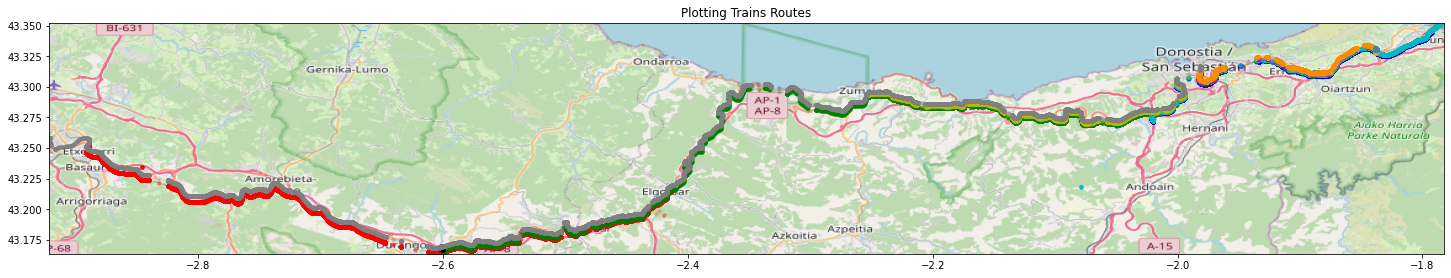

In [ ]:
import matplotlib.pyplot as plt
import imageio
import matplotlib.cm as cm
import itertools

b_map = imageio.imread('drive/MyDrive/CAFcoding/notebook/utils/map.png')
colors = itertools.cycle(["r", "b", "g", "c", "m", "y", "k", "darkorange", "steelblue", "grey"])

fig, ax = plt.subplots(figsize = (25,10))

# Utilizar la ut_list del notebook 5, y hacer el ordenado.
for i,t in enumerate(df['ut'].unique()):
  dfr = df[df['ut'] == t]
  ax.scatter(dfr.Longitud, dfr.Latitud + (i*0.0005), zorder=1, alpha= 0.2, c=next(colors), s=10)

ax.imshow(b_map, zorder=0, extent=b_box, aspect='equal')
ax.set_title('Plotting Trains Routes')
ax.set_xlim(b_box[0],b_box[1])
ax.set_ylim(b_box[2],b_box[3])

In [ ]:
station_coords = []
for e in df_meteo.estacion.unique():
  station_coord_obj = {'id': e, 
                       'long': df_meteo[df_meteo['estacion'] == e]['longitud'].max(), 
                       'lat':df_meteo[df_meteo['estacion'] == e]['latitud'].max()}
  station_coords.append(station_coord_obj);

station_coords

[{'id': '1074C', 'lat': 43.202892, 'long': -2.706153},
 {'id': 1082, 'lat': 43.29795, 'long': -2.906304},
 {'id': '1012P', 'lat': 43.326409999999996, 'long': -1.7965360000000001},
 {'id': '1041A', 'lat': 43.30214, 'long': -2.251035},
 {'id': '1050J', 'lat': 43.209293, 'long': -2.413218}]

In [ ]:
df_meteo.drop(['id', 'ciudad', 'temp_rocio', 'longitud', 'latitud'], axis="columns", inplace=True)

In [ ]:
df=df.sort_values(by=['ut','ts_date'])

In [ ]:
df['Nearest_Station'] = df.apply(lambda r : getNearestStation(r.Longitud, r.Latitud)['id'], axis=1)

In [ ]:
df['Latitud-1']=df["Latitud"].shift(periods=-1) # Sentido 1 o -1
df['Longitud-1']=df["Longitud"].shift(periods=-1)

In [ ]:
df["Direction"] = df.apply(lambda r: getTrainDirection(r["Latitud-1"], 
                                                               r["Longitud-1"],
                                                               r["Latitud"], 
                                                               r["Longitud"]), axis=1)

In [ ]:
#Preparando Merge y ejecutando
df_meteo['Nearest_Station'] = df_meteo['estacion']
df_meteo['ts_date'] = df_meteo['fecha']

df_meteo['ts_date'] = pd.to_datetime(df_meteo.ts_date,format="%Y/%m/%d %H:%M:%S.%f" )
df['ts_date'] = pd.to_datetime(df.ts_date,format="%Y/%m/%d %H:%M:%S.%f" )

df_meteo = df_meteo.groupby('Nearest_Station').apply(lambda x: x.sort_values('ts_date'))
df_meteo = df_meteo.set_index(['Nearest_Station','ts_date'])

df = df.join(df_meteo, on=["Nearest_Station", "ts_date"])

In [ ]:
#Rellenamos los valores
list_ut = df.ut.unique()

list_df = []
for ut in list_ut:
  df_tmp = df[df.ut==ut]#.asfreq(delta)
  for field in df_tmp.columns:
    df_tmp[field] = df_tmp[field].fillna(method='bfill')
  for field in df_tmp.columns:
    df_tmp[field] = df_tmp[field].fillna(method='ffill')  
  list_df.append(df_tmp)
df = pd.concat(list_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [ ]:
df['fr_wind'] = df.apply(lambda x: fr_aerodinamic_wind(x['wind_vmean_10m'], x['wind_direction_10m'], x['Direction']), axis=1)
df['lat_wind'] = df.apply(lambda x: lat_aerodinamic_wind(x['wind_vmean_10m'], x['wind_direction_10m'], x['Direction']), axis=1)

In [ ]:
#Alturas
elevation_data = srtm.get_data()

df['altitude'] = df.apply(lambda x: float(elevation_data.get_elevation(x['Latitud'], x['Longitud'])), axis=1)
df['altitude-1'] = df.apply(lambda x: float(elevation_data.get_elevation(x['Latitud-1'], x['Longitud-1'])), axis=1)
df['slope'] = df.apply(lambda x: (x['altitude'] - x['altitude-1']) and (1, -1)[(x['altitude'] - x['altitude-1'])<0], axis=1)
df['distance'] = df.apply(lambda x: distance(x['Latitud'], x['Longitud'], x['Latitud-1'], x['Longitud-1']), axis=1)
df['percent_slope'] = df.apply(lambda x: ((x['altitude'] - x['altitude-1'])/x['distance'])*100 if x['distance'] != 0 else np.nan, axis=1)

In [ ]:
#Eliminamos los momentos en el el que el tren está parado
#No tenemos nulls a esta altura a excepción de cuando se encuentra parado

df = df.dropna(how='any',axis=0) 

In [ ]:
columns_to_drop = ['SI_GPS_LatS', 'SI_GPS_LatM', 'SI_GPS_LatG', 'SI_GPS_LatFracS', 'SI_GPS_LonG', 'SI_GPS_LonM',
                   'SI_GPS_LonS', 'SI_GPS_LonFracS', 'Norte', 'Este', 'Nearest_Station',
                   'Direction', 'estacion', 'fecha', 'wind_vmax_3s', 'wind_vmean_10m', 'wind_direction_10m',
                   'wind_max_direction_60m', 'tia', 'tmin', 'tmax', 'Latitud-1', 'Longitud-1', 'Latitud', 'Longitud', 'altitude-1']

df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ut,142792.0,915.972316,7.048676,906.000000,912.000000,914.000000,9.240000e+02,9.260000e+02
TCU1_LinePowerConsumed,142792.0,56135.714942,85580.964707,0.000000,0.000000,7052.500000,7.759300e+04,2.892145e+05
TCU1_LinePowerDissipated,142792.0,14380.874643,44924.497722,0.000000,0.000000,0.000000,0.000000e+00,4.937835e+05
TCU1_LinePowerReturned,142792.0,17053.871092,40030.363618,0.000000,0.000000,0.000000,7.052500e+03,3.950330e+05
TCU2_LinePowerConsumed,142792.0,55842.925031,85338.038464,0.000000,0.000000,7052.500000,7.759300e+04,2.962670e+05
TCU2_LinePowerDissipated,142792.0,15432.411221,46679.837865,0.000000,0.000000,0.000000,0.000000e+00,4.620395e+05
TCU2_LinePowerReturned,142792.0,15933.103381,37939.649195,0.000000,0.000000,0.000000,8.804000e+03,4.073710e+05
TCU3_LinePowerConsumed,142792.0,56139.648233,85620.983760,0.000000,0.000000,7052.500000,7.759300e+04,2.962670e+05
TCU3_LinePowerDissipated,142792.0,14562.059496,45376.080766,0.000000,0.000000,0.000000,0.000000e+00,4.761600e+05
TCU3_LinePowerReturned,142792.0,16870.947385,39772.176882,0.000000,0.000000,0.000000,8.804000e+03,3.914990e+05


# Comprobamos cuantos trenes tenemos y nos quedamos con uno solo para el analisis


Comprobamos campos nulos

In [ ]:
print ("Pintamos columnas con valores nulos")
list_nulls = 0
for column in df.columns:
  if df[column].isna().any():
    list_nulls +=1
    print (column, df[column].isna().any(), df[column].isna().sum())
if list_nulls==0:
  print ("No hay valores nulos")

Pintamos columnas con valores nulos
No hay valores nulos


# Comprobamos los tipos de las columnas

In [ ]:
for column in df.columns:
  print (column, df[column].dtypes)

ut int32
ts_date datetime64[ns]
TCU1_LinePowerConsumed float64
TCU1_LinePowerDissipated float64
TCU1_LinePowerReturned float64
TCU2_LinePowerConsumed float64
TCU2_LinePowerDissipated float64
TCU2_LinePowerReturned float64
TCU3_LinePowerConsumed float64
TCU3_LinePowerDissipated float64
TCU3_LinePowerReturned float64
TCU4_LinePowerConsumed float64
TCU4_LinePowerDissipated float64
TCU4_LinePowerReturned float64
TCU1_DCBusVoltage float64
TCU2_DCBusVoltage float64
TCU3_DCBusVoltage float64
TCU4_DCBusVoltage float64
TCU1_CatenaryVoltage float64
TCU2_CatenaryVoltage float64
TCU3_CatenaryVoltage float64
TCU4_CatenaryVoltage float64
TCU1_Axle1Speed float64
TCU2_Axle1Speed float64
TCU3_Axle1Speed float64
TCU4_Axle1Speed float64
TCU1_Axle2Speed float64
TCU2_Axle2Speed float64
TCU3_Axle2Speed float64
TCU4_Axle2Speed float64
ER_TotKm float64
Manual bool
ImpSpeedMode bool
ManEficient bool
ManeuverMode bool
AutoEficient bool
Coupled bool
TCU1_ElecEffApp float64
TCU2_ElecEffApp float64
TCU3_ElecEffApp

# Analizamos las columnas para convertirlos a valores numericos



In [ ]:

object_2_float = list(df.columns)
object_2_float.remove('ut')
object_2_float.remove('ts_date')


In [ ]:
dict_types = {}
for field in object_2_float:
  if not df[field].dtypes in dict_types:
    dict_types[df[field].dtypes]=[]
  dict_types[df[field].dtypes].append(field)  
  

## Convertimos variables booleanas a categoricas


In [ ]:
for field in dict_types[np.dtype('bool')]:
  print (field, df[field].dtypes)
  df[field] = df[field].apply(lambda x: 1 if x else 0)

Manual bool
ImpSpeedMode bool
ManEficient bool
ManeuverMode bool
AutoEficient bool
Coupled bool


## Analizamos variables int8

In [ ]:
for field in dict_types[np.dtype('int8')]: #cuidado con los tipos
  print(df[field].value_counts())

0    81650
1    61142
Name: PLC_DS_CAB1, dtype: int64
0    76809
1    65983
Name: PLC_DS_CAB2, dtype: int64
2    57787
3    45052
1    39952
0        1
Name: PLC_MASTER_CONTROLLER_POS, dtype: int64


### Generamos variable categorica para PLC_MASTER_CONTROLLER_POS
0. Urgency Brake Requested
1. Braking effort requested
2. Coasting requested
3. Propulsion effort requested
4. Error or unknown request



In [ ]:
plc_mcp_dict={0:"plc_mcp_urgency_brake_requested",
              1:"plc_mcp_braking_effort_requested",
              2:"plc_mcp_coasting_requested",
              3:"plc_mcp_propulsion_effort_requested",
              4:"plc_mcp_error_unknown_requested"}

for key in plc_mcp_dict:
  df[plc_mcp_dict[key]] = np.where(df['PLC_MASTER_CONTROLLER_POS']==key,1,0)



In [ ]:
#df.drop(['PLC_MASTER_CONTROLLER_POS'], axis=1, inplace=True)
#object_2_float.remove('PLC_MASTER_CONTROLLER_POS')

## Analizamos variables int16

In [ ]:
for field in dict_types[np.dtype('int16')]:
  print(df[field].value_counts())

0      142751
128         9
64          8
40          4
4           3
1           2
2           2
8           2
20          2
21          2
16          1
10          1
32          1
160         1
34          1
168         1
65          1
Name: EPAC1_WSP_Acting, dtype: int64
0      142749
64          6
4           6
40          5
128         5
16          4
20          3
1           3
32          2
136         2
2           2
84          1
168         1
34          1
160         1
8           1
Name: EPAC2_WSP_Acting, dtype: int64


## Convertimos tipo object

In [ ]:
for field in dict_types[np.dtype('object')]:
  print(df[field].value_counts())

65    32941
76    21313
79    14311
0     11224
90    10741
69     7890
66     7397
77     7232
71     6585
73     5521
83     3745
85     2627
84     2588
70     2497
68     2281
82     1902
80     1327
72      670
Name: ER_EUIdSenal1, dtype: int64
65    22139
82    17663
69    15388
79    14303
77    12109
0     11224
78     8995
73     8771
45     7085
85     6344
95     5520
81     4950
76     4370
83     1370
80      785
88      760
90      537
71      230
75      213
84       36
Name: ER_EUIdSenal2, dtype: int64
65    24006
73    23081
79    14160
82    12492
0     11224
78     8593
85     7148
83     7139
77     5925
76     5589
66     5333
90     4633
68     3295
69     2644
71     2495
75     2276
84     1562
67      630
81      409
70      122
88       36
Name: ER_EUIdSenal3, dtype: int64
95    131568
0      11224
Name: ER_EUIdSenal4, dtype: int64
83    54345
69    37215
80    19189
0     11224
84    11018
73     9801
Name: ER_EUIdSenal5, dtype: int64
50    54852
49    42870


In [ ]:
def convert2float(value):
  return float(value.replace(',','.'))


for field in dict_types[np.dtype('object')]:
  print (field, df[field].dtypes)
  # if df[field].dtypes != "float":
  df[field] = df[field].apply(lambda x: convert2float(x))

ER_EUIdSenal1 object
ER_EUIdSenal2 object
ER_EUIdSenal3 object
ER_EUIdSenal4 object
ER_EUIdSenal5 object
ER_EUIdSenal6 object
ER_EUIdSenal7 object
ER_EUIdSenal8 object


## Convertimos el campo fecha

In [ ]:
#df.ts_date.describe()

In [ ]:
# df['date'] = pd.to_datetime(df.ts_date,format="%Y/%m/%d %H:%M:%S.%f" )#utc=True, infer_datetime_format=True)
#df['ts_date'] = pd.to_datetime(df.ts_date,format="%Y/%m/%d %H:%M:%S.%f" )#utc=True, infer_datetime_format=True)
#df['date'] = pd.to_datetime(df.ts_date,format="%Y/%m/%d %H:%M:%S.%f")#yearfirst=True)#, infer_datetime_format=True)#format="%Y-%m-%dT%H:%M:%S.%f%z" )#yearfirst=True, 

In [ ]:
#df['date'].describe()

In [ ]:
#ts_date = df['date']

## Ordenamos dataframe por el campo ts_date


In [ ]:
# Ordenamos por ut por si tenemos todos los trenes
#df=df.sort_values(by=['ut','ts_date'])

#df=df.sort_values(by=['ts_date'])
#df.head()


In [ ]:
# Guardamos ts_date para poder determinar la frequencia mas tarde
ts_date = df[df.ut==list_ut[0]]['ts_date']

df.set_index('ts_date', inplace=True)
df['ts_date'] = df.index

In [ ]:
df.head()

,ut,TCU1_LinePowerConsumed,TCU1_LinePowerDissipated,TCU1_LinePowerReturned,TCU2_LinePowerConsumed,TCU2_LinePowerDissipated,TCU2_LinePowerReturned,TCU3_LinePowerConsumed,TCU3_LinePowerDissipated,TCU3_LinePowerReturned,TCU4_LinePowerConsumed,TCU4_LinePowerDissipated,TCU4_LinePowerReturned,TCU1_DCBusVoltage,TCU2_DCBusVoltage,TCU3_DCBusVoltage,TCU4_DCBusVoltage,TCU1_CatenaryVoltage,TCU2_CatenaryVoltage,TCU3_CatenaryVoltage,TCU4_CatenaryVoltage,TCU1_Axle1Speed,TCU2_Axle1Speed,TCU3_Axle1Speed,TCU4_Axle1Speed,TCU1_Axle2Speed,TCU2_Axle2Speed,TCU3_Axle2Speed,TCU4_Axle2Speed,ER_TotKm,Manual,ImpSpeedMode,ManEficient,ManeuverMode,AutoEficient,Coupled,TCU1_ElecEffApp,TCU2_ElecEffApp,TCU3_ElecEffApp,TCU4_ElecEffApp,PLC_TRACTION_BRAKE_COMMAND,PLC_Speed,PLC_TempExt,PLC_DS_CAB1,PLC_DS_CAB2,EPAC1_WSP_Acting,EPAC2_WSP_Acting,PLC_MassM1,PLC_MassM2,PLC_MassR1,PLC_MassR2,PLC_VLinea_M1,PLC_VLinea_M2,ER_EUIdSenal1,ER_EUIdSenal2,ER_EUIdSenal3,ER_EUIdSenal4,ER_EUIdSenal5,ER_EUIdSenal6,ER_EUIdSenal7,ER_EUIdSenal8,PLC_MASTER_CONTROLLER_POS,SI_GPS_Speed,precipitacion_pluviometro_acu,hri,fr_wind,lat_wind,altitude,slope,distance,percent_slope,plc_mcp_urgency_brake_requested,plc_mcp_braking_effort_requested,plc_mcp_coasting_requested,plc_mcp_propulsion_effort_requested,plc_mcp_error_unknown_requested,ts_date
ts_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-18 04:55:23,906,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,232779.0,0.0,0.0,1688.942857,1682.300000,1684.342857,1687.442857,1683.485714,1693.814286,1686.928571,1688.542857,235.528571,231.157143,-234.271429,-231.771429,235.685714,231.471429,-233.757143,-231.0000,918999.0,1,0,0,0,0,0,15.940000,15.822000,16.044667,15.868000,75.493333,57.206667,16.5,1,0,0,0,32820.0,32820.0,26800.0,26800.0,1693.733333,1687.400000,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3,96.3,0.0,44.0,-1.459889,4.362193,145.0,0.0,22.588543,0.000000,0,0,0,1,0,2020-11-18 04:55:23
2020-11-18 04:55:24,906,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,1686.500000,1684.575000,1683.737500,1684.587500,1693.412500,1699.437500,1695.812500,1697.900000,239.625000,235.237500,-238.662500,-235.675000,239.875000,235.262500,-237.637500,-234.9875,918999.0,1,0,0,0,0,0,15.495000,15.656250,15.444375,15.716875,75.400000,58.237500,16.5,1,0,0,0,32820.0,32820.0,26800.0,26800.0,1695.125000,1696.375000,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3,100.0,0.0,44.0,-1.459889,4.362193,145.0,1.0,22.588543,13.281069,0,0,0,1,0,2020-11-18 04:55:24
2020-11-18 04:55:25,906,232779.0,0.0,0.0,239831.5,0.0,0.0,232779.0,0.0,0.0,239831.5,0.0,0.0,1683.500000,1679.687500,1679.987500,1682.562500,1677.687500,1691.975000,1699.725000,1693.550000,243.762500,239.650000,-242.562500,-239.687500,244.112500,239.325000,-241.625000,-239.2625,918999.0,1,0,0,0,0,0,15.501250,15.186875,15.356250,15.146250,66.462500,59.225000,16.5,1,0,0,0,32820.0,32820.0,26800.0,26800.0,1684.687500,1696.250000,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3,103.7,0.0,44.0,-1.459889,4.362193,142.0,0.0,22.588543,0.000000,0,0,0,1,0,2020-11-18 04:55:25
2020-11-18 04:55:26,906,239831.5,0.0,0.0,232779.0,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,1681.775000,1681.575000,1678.587500,1680.625000,1681.212500,1695.750000,1689.600000,1700.400000,248.037500,243.737500,-246.562500,-243.675000,248.250000,243.512500,-245.775000,-243.5500,918999.0,1,0,0,0,0,0,14.812667,15.190000,15.103333,15.158000,61.280000,60.260000,16.5,1,0,0,0,32820.0,32820.0,26800.0,26800.0,1686.866667,1694.066667,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3,105.5,0.0,44.0,3.008866,-3.479472,142.0,0.0,38.243689,0.000000,0,0,0,1,0,2020-11-18 04:55:26
2020-11-18 04:55:28,906,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,1678.900000,1674.014286,1677.285714,1680.800000,1689.885714,1688.185714,1688.285714,1698.985714,255.700000,251.342857,-254.285714,-251.100000,255.771429,251.214286,-253.914286,-251.1000,918999.0,1,0,0,0,0,0,14.806667,14.501333,14.680667,14.498667,61.260000,62.133333,16.5,1,0,0

In [ ]:
#print (ts_date.index)
type(ts_date[:1])

pandas.core.series.Series

## Intentamos detectar la frecuencia

In [ ]:
print(pd.infer_freq(ts_date))

None


Como es None intentamos buscar el delta minimo entre timestamp

In [ ]:
delta = ts_date.diff()
print (delta)
print (delta.min(),delta.max())

17723               NaT
17724   0 days 00:00:01
17725   0 days 00:00:01
17726   0 days 00:00:01
17728   0 days 00:00:02
              ...      
77165   0 days 00:00:01
77196   0 days 00:00:31
77197   0 days 00:00:01
77301   0 days 00:01:44
86399   0 days 02:31:38
Name: ts_date, Length: 17312, dtype: timedelta64[ns]
0 days 00:00:01 0 days 02:31:38


In [ ]:
delta = ts_date.diff().min()
print (delta)

0 days 00:00:01


# Aplicamos la frequencia de muestreo esperada en los datos
## Y rellenamos los nuevos campos

In [ ]:
list_df = []
for ut in list_ut:
  df_tmp = df[df.ut==ut].asfreq(delta)
  for field in df_tmp.columns:
    df_tmp[field] = df_tmp[field].fillna(method='bfill')
  for field in df_tmp.columns:
    df_tmp[field] = df_tmp[field].fillna(method='ffill')  
  list_df.append(df_tmp)
df = pd.concat(list_df)

In [ ]:
df.head()

,ut,TCU1_LinePowerConsumed,TCU1_LinePowerDissipated,TCU1_LinePowerReturned,TCU2_LinePowerConsumed,TCU2_LinePowerDissipated,TCU2_LinePowerReturned,TCU3_LinePowerConsumed,TCU3_LinePowerDissipated,TCU3_LinePowerReturned,TCU4_LinePowerConsumed,TCU4_LinePowerDissipated,TCU4_LinePowerReturned,TCU1_DCBusVoltage,TCU2_DCBusVoltage,TCU3_DCBusVoltage,TCU4_DCBusVoltage,TCU1_CatenaryVoltage,TCU2_CatenaryVoltage,TCU3_CatenaryVoltage,TCU4_CatenaryVoltage,TCU1_Axle1Speed,TCU2_Axle1Speed,TCU3_Axle1Speed,TCU4_Axle1Speed,TCU1_Axle2Speed,TCU2_Axle2Speed,TCU3_Axle2Speed,TCU4_Axle2Speed,ER_TotKm,Manual,ImpSpeedMode,ManEficient,ManeuverMode,AutoEficient,Coupled,TCU1_ElecEffApp,TCU2_ElecEffApp,TCU3_ElecEffApp,TCU4_ElecEffApp,PLC_TRACTION_BRAKE_COMMAND,PLC_Speed,PLC_TempExt,PLC_DS_CAB1,PLC_DS_CAB2,EPAC1_WSP_Acting,EPAC2_WSP_Acting,PLC_MassM1,PLC_MassM2,PLC_MassR1,PLC_MassR2,PLC_VLinea_M1,PLC_VLinea_M2,ER_EUIdSenal1,ER_EUIdSenal2,ER_EUIdSenal3,ER_EUIdSenal4,ER_EUIdSenal5,ER_EUIdSenal6,ER_EUIdSenal7,ER_EUIdSenal8,PLC_MASTER_CONTROLLER_POS,SI_GPS_Speed,precipitacion_pluviometro_acu,hri,fr_wind,lat_wind,altitude,slope,distance,percent_slope,plc_mcp_urgency_brake_requested,plc_mcp_braking_effort_requested,plc_mcp_coasting_requested,plc_mcp_propulsion_effort_requested,plc_mcp_error_unknown_requested,ts_date
ts_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-18 04:55:23,906.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,232779.0,0.0,0.0,1688.942857,1682.300000,1684.342857,1687.442857,1683.485714,1693.814286,1686.928571,1688.542857,235.528571,231.157143,-234.271429,-231.771429,235.685714,231.471429,-233.757143,-231.0000,918999.0,1.0,0.0,0.0,0.0,0.0,0.0,15.940000,15.822000,16.044667,15.868000,75.493333,57.206667,16.5,1.0,0.0,0.0,0.0,32820.0,32820.0,26800.0,26800.0,1693.733333,1687.400000,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3.0,96.3,0.0,44.0,-1.459889,4.362193,145.0,0.0,22.588543,0.000000,0.0,0.0,0.0,1.0,0.0,2020-11-18 04:55:23
2020-11-18 04:55:24,906.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,1686.500000,1684.575000,1683.737500,1684.587500,1693.412500,1699.437500,1695.812500,1697.900000,239.625000,235.237500,-238.662500,-235.675000,239.875000,235.262500,-237.637500,-234.9875,918999.0,1.0,0.0,0.0,0.0,0.0,0.0,15.495000,15.656250,15.444375,15.716875,75.400000,58.237500,16.5,1.0,0.0,0.0,0.0,32820.0,32820.0,26800.0,26800.0,1695.125000,1696.375000,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3.0,100.0,0.0,44.0,-1.459889,4.362193,145.0,1.0,22.588543,13.281069,0.0,0.0,0.0,1.0,0.0,2020-11-18 04:55:24
2020-11-18 04:55:25,906.0,232779.0,0.0,0.0,239831.5,0.0,0.0,232779.0,0.0,0.0,239831.5,0.0,0.0,1683.500000,1679.687500,1679.987500,1682.562500,1677.687500,1691.975000,1699.725000,1693.550000,243.762500,239.650000,-242.562500,-239.687500,244.112500,239.325000,-241.625000,-239.2625,918999.0,1.0,0.0,0.0,0.0,0.0,0.0,15.501250,15.186875,15.356250,15.146250,66.462500,59.225000,16.5,1.0,0.0,0.0,0.0,32820.0,32820.0,26800.0,26800.0,1684.687500,1696.250000,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3.0,103.7,0.0,44.0,-1.459889,4.362193,142.0,0.0,22.588543,0.000000,0.0,0.0,0.0,1.0,0.0,2020-11-18 04:55:25
2020-11-18 04:55:26,906.0,239831.5,0.0,0.0,232779.0,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,1681.775000,1681.575000,1678.587500,1680.625000,1681.212500,1695.750000,1689.600000,1700.400000,248.037500,243.737500,-246.562500,-243.675000,248.250000,243.512500,-245.775000,-243.5500,918999.0,1.0,0.0,0.0,0.0,0.0,0.0,14.812667,15.190000,15.103333,15.158000,61.280000,60.260000,16.5,1.0,0.0,0.0,0.0,32820.0,32820.0,26800.0,26800.0,1686.866667,1694.066667,76.0,69.0,66.0,95.0,83.0,53.0,84.0,0.0,3.0,105.5,0.0,44.0,3.008866,-3.479472,142.0,0.0,38.243689,0.000000,0.0,0.0,0.0,1.0,0.0,2020-11-18 04:55:26
2020-11-18 04:55:27,906.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,239831.5,0.0,0.0,1678.900000,1674.014286,1677.285714,1680.800000,1689.885714,1688.185714,1688.285714,1698.985714,255.700000,251.342857,-254.285714,-251.1000

In [ ]:
df.isna().sum()

ut                                     0
TCU1_LinePowerConsumed                 0
TCU1_LinePowerDissipated               0
TCU1_LinePowerReturned                 0
TCU2_LinePowerConsumed                 0
                                      ..
plc_mcp_braking_effort_requested       0
plc_mcp_coasting_requested             0
plc_mcp_propulsion_effort_requested    0
plc_mcp_error_unknown_requested        0
ts_date                                0
Length: 77, dtype: int64

In [ ]:
df.dtypes

ut                                            float64
TCU1_LinePowerConsumed                        float64
TCU1_LinePowerDissipated                      float64
TCU1_LinePowerReturned                        float64
TCU2_LinePowerConsumed                        float64
                                            ...      
plc_mcp_braking_effort_requested              float64
plc_mcp_coasting_requested                    float64
plc_mcp_propulsion_effort_requested           float64
plc_mcp_error_unknown_requested               float64
ts_date                                datetime64[ns]
Length: 77, dtype: object

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ut,754247.0,917.175787,6.607959,906.0,912.0,918.0,924.0,926.0
TCU1_LinePowerConsumed,754247.0,34778.984203,69261.055212,0.0,0.0,0.0,21157.5,289214.5
TCU1_LinePowerDissipated,754247.0,7710.288667,32469.334030,0.0,0.0,0.0,0.0,493783.5
TCU1_LinePowerReturned,754247.0,15566.185006,43494.713025,0.0,0.0,0.0,0.0,395033.0
TCU2_LinePowerConsumed,754247.0,34492.191283,69003.538696,0.0,0.0,0.0,21157.5,296267.0
...,...,...,...,...,...,...,...,...
plc_mcp_urgency_brake_requested,754247.0,0.000001,0.001151,0.0,0.0,0.0,0.0,1.0
plc_mcp_braking_effort_requested,754247.0,0.186611,0.389599,0.0,0.0,0.0,0.0,1.0
plc_mcp_coasting_requested,754247.0,0.583910,0.492909,0.0,0.0,1.0,1.0,1.0
plc_mcp_propulsion_effort_requested,754247.0,0.229478,0.420497,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.to_csv(csv_path, index=True, index_label="ts_date_index")